# Topography ray tracing and distance estimation

In this work we create a python script able to get a volcano topography, convert it to local dimensions, locate a observation point, ray trace the target and estimate the crosing distance. This was based on the master work of Alejandra Vesga-Ramírez coded in MATLAB.

https://www.annalsofgeophysics.eu/index.php/annals/article/view/8353

Steps followed by A. Vesga-Ramirez:

1. Descarga archivos.hgt a partir del modelo digital de elevación de la NASA STRM1 correspondiente a una resolución de 90mX90m imágenes de la NASA con resolución 90mX90m y vuelve las coordenadas latitud y longitud en vectores con una matriz de valores de elevación.
2. Permite seleccionar el área de trabajo y graficar en 3D.
3. Redefine el sistema de referencia (grados decimales) a un sistema de referencia local (metros) mediante un factor de conversión de grados a metros.
4. Se interpola la altura a partir de la definición de un punto de observación en 2D, con base a los datos del modelo digital de elevación NASA y se ubica este punto de observación sobre la topografía.
5. Se trazan líneas que atraviesan la topografía a partir de este punto se observación 3D , variando el ángulo azimutal y horizontal. Para esto, se define la variación ángulo azimut medido desde el eje X, se define la variación del ángulo cenit.
6. Se calculan finalmente las distancias recorridas en roca por cada dirección del muon, considerando en detalle la topografía alrededor de cada volcán que está disponible en el modelo de elevación digital global de la Tierra en NASA Shuttle Radar Topography Mission (SRTM) 1, con resolución SRTM3 90m×90m.

## Topography data import

To upload the topography data we use the python module:

https://pypi.org/project/python-srtm/

Module installation

!pip3.9 install python-srtm

Data were donwnloaded from:

https://opendap.cr.usgs.gov/opendap/hyrax/DP133/SRTM/SRTMGL1.003/2000.02.11/contents.html

https://e4ftl01.cr.usgs.gov/MEASURES/SRTMGL1.003/2000.02.11/SRTMGL1_page_1.html

http://step.esa.int/auxdata/dem/SRTMGL1/?C=N;O=D


Upload data:

rsync -avh SRTM_file  penaj@jupyter.redclara.net:/home/penaj/Python3.8/SRTM1
pass: l4c0ng4*2t3032i

In [1]:
# !export SRTM1_DIR=/home/penaj/Python3.8/SRTM1
# !export SRTM3_DIR=/home/penaj/Python3.8/SRTM3
%env SRTM1_DIR=/home/penaj/Python3.8/SRTM1
%env SRTM3_DIR=/home/penaj/Python3.8/SRTM3

env: SRTM1_DIR=/home/penaj/Python3.8/SRTM1
env: SRTM3_DIR=/home/penaj/Python3.8/SRTM3


In [2]:
# SRTM1 - 30m resolution
from srtm import Srtm1HeightMapCollection
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
import pyproj
import sys

In [3]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    
    # Progress bar animation
    count = len(it)
    def show(j):
        x = int(size*j/count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#"*x, "."*(size-x), j*100/count, 100))
        file.flush()        
    show(0)
    for i, item in enumerate(it):
        yield item
        show(i+1)
    file.write("\n")
    file.flush()

In [4]:
def line_eq (x, a, b):
    y = a*x + b
    return y

In [5]:
def ray_tracing(R, Max_Ele, D_azim, cenith, azimuth, Po_x, Po_y, Po_Ele, Po_Lat, Po_Log, Latitudes, Longitudes):
    
    # Estimation of the sky projection
    

    theta = Max_Ele - cenith # radians
    phi = -D_azim + azimuth

    b = np.abs(R*np.sin(phi)*np.cos(theta))
    a = np.abs(R*np.cos(phi)*np.cos(theta))
    c = R*np.sin(theta)*1000

    Ps_x = Po_x + a
    Ps_y = Po_y + b
    Ps_z = Po_Ele + c

#    print ("Projected point a = %f, b = %f, c = %f" % (Ps_x, Ps_y, Ps_z))

    Px = [Po_x, Ps_x ]
    Py = [Po_y, Ps_y]
    Pz = [Po_Ele, Ps_z]
    
    
    # XY ray projection, line equation extraction and generation of XY point for extraction elevation profiles

    # fit curve
    popt, ppam = curve_fit(line_eq, Px, Py)

    N = 1000 # number of evaluation points

    X_p = np.linspace(Po_x, Ps_x, N)
    Y_p = popt[0]*X_p + popt[1]
    
    # Convert XY coordinates to Lat and Long for elevation evaluation

    R_earth = 6371.0 # km

    Ps_Lat  = Latitudes[0]  - (Ps_y / R_earth) * (180.0 / np.pi)
    Ps_Log = Longitudes[0] - (Ps_x / R_earth) * (180.0 / np.pi) / np.cos(Po_Lat * np.pi/180.0)

    P_Lat = [Po_Lat, Ps_Lat ]
    P_Log = [Po_Log, Ps_Log]

#    print ("Projection Lat : %f and Long : %f" % (Ps_Lat, Ps_Log))
    
    # fit curve
    popt, ppam = curve_fit(line_eq, P_Log, P_Lat)

    N = 1000 # number of evaluation points

    Log_p = np.linspace(Po_Log, Ps_Log, N)
    Lat_p = popt[0]*Log_p + popt[1]

    # Get elevation profile

    Profile = np.zeros(N)

    for i in range(N):
            Profile[i] = srtm1_data.get_altitude(latitude=Lat_p[i], longitude=Log_p[i])

            
    X_p2 = np.zeros(N)
    Y_p2 = np.zeros(N)

    for i in range(N):

        X_p2[i] = (Longitudes[0]-Log_p[i])*40000*math.cos((Latitudes[0]+Lat_p[i])*math.pi/180.0)/360.0
        Y_p2[i] = (Latitudes[0]-Lat_p[i])*40000/360.0
    
    # Compute traverssing distance
    
    M = len(X_p2)
    x_fit = np.linspace(Po_x, Ps_x, M)


    # fit curve
    popt, ppam = curve_fit(line_eq, [Po_x, Ps_x], [Po_Ele, Ps_z])

    y_fit = popt[0]*x_fit + popt[1]
    
    index = []

    for i in range(M):
        if y_fit[i] < Profile[i]:
            index.append(i)
    
    if index == []: # If the projected ray is outside the target
        distance = 0
    else:
        distance = X_p2[index[-1]] - X_p2[index[0]]
    
#     fig = plt.figure(figsize=(15,5))
#     plt.plot(X_p2, Profile)
#     plt.plot(x_fit, y_fit, 'r')
#     plt.plot(X_p2[index[0]], Profile[index[0]], 'ok')
#     plt.plot(X_p2[index[-1]], Profile[index[-1]], 'ok')

#     plt.xlabel("X [km]", fontsize=20)
#     plt.ylabel("Elevation [m a.s.l.]", fontsize=20)

#    print ("Distance %f km" % (distance))
           
    return distance

In [6]:
srtm1_data = Srtm1HeightMapCollection()
srtm1_data.build_file_index()

## Import topography

In [33]:
M = 100 # Resolution

# Sites

# Latitudes = np.linspace(-0.665310, -0.707996, M) # Cotopaxi
# Longitudes = np.linspace(-78.411750, -78.460185, M)

Latitudes = np.linspace(35.342267, 35.390034, M) # Monte Fuji
Longitudes = np.linspace(138.693145, 138.775231, M)

# Latitudes = np.linspace(4.466944, 4.500833, M) # Machin
# Longitudes = np.linspace(-75.3625, -75.40472, M)

# Latitudes = np.linspace(13.306654, 13.357685, M) # Guadalupe, La Sufriere
# Longitudes = np.linspace(-61.153850, -61.198964, M)


Elevations = np.zeros((M,M))

for i in range(M):
    for j in range(M):
        Elevations[i,j]= srtm1_data.get_altitude(latitude=Latitudes[i], longitude=Longitudes[j])

## Convert to meters

In [34]:
import math

Ce = 40075 # Earth circunference km
X_meter = np.zeros(M)
Y_meter = np.zeros(M)

for i in range(M):
    
    X_meter[i] = Ce*(Longitudes[0]-Longitudes[i])*np.cos((Latitudes[0]-Latitudes[i])*np.pi/180.0)/360.0 # Lenght Longitud
    Y_meter[i] = Ce*(Latitudes[0]-Latitudes[i])/360.0 # Lenght Latitude

## Locate observation point in topography

In [35]:
from IPython.display import Image
Image(url= "Puntos_Machin.png", width=800, height=400)

In [36]:
# Po_Log = -78.418289 # Cotopaxi
# Po_Lat = -0.682502

Po_Log = 138.757963 # Fuji P1
Po_Lat = 35.365945

# Po_Log = -75.380085 # Machin
# Po_Lat = 4.491984

#Po_Log = -61.195334 # Soufriere
#Po_Lat = 13.331896

Po_Ele = srtm1_data.get_altitude(latitude=Po_Lat, longitude=Po_Log)
    
Po_x = Ce*(Longitudes[0] - Po_Log)*np.cos((Latitudes[0] - Po_Lat)*np.pi/180.0)/360.0
Po_y = Ce*(Latitudes[0] - Po_Lat)/360.0

Text(0.5, 0, 'Elevation [m a.s.l]')

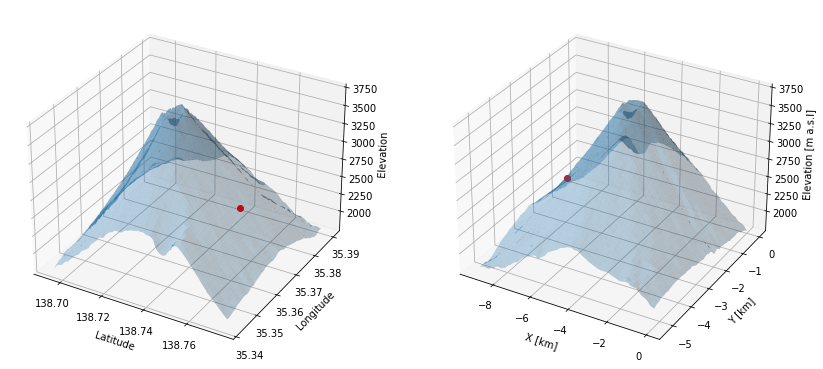

In [37]:
# Global and local coordinates comparison

fig = plt.figure(figsize=(14,18))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(Longitudes, Latitudes)
Z = Elevations.reshape(X.shape)

ax.plot_surface(X, Y, Z, alpha=0.3)
ax.plot(Po_Log, Po_Lat, Po_Ele,'or')

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Elevation')

ax1 = fig.add_subplot(122, projection='3d')
Xm, Ym = np.meshgrid(X_meter, Y_meter)
Zm = Elevations.reshape(Xm.shape)

ax1.plot_surface(Xm, Ym, Elevations, alpha=0.3)
ax1.plot(Po_x, Po_y, Po_Ele, 'or')

ax1.set_xlabel('X [km]')
ax1.set_ylabel('Y [km]')
ax1.set_zlabel('Elevation [m a.s.l]')


## Ray tracing

Define azimuth $\phi$, cenith angle $\theta$, projection distance $R$ and the projected point coordinates (a,b,c)



In [13]:
# Highest point of the dome as a reference for pointing the telescope

# Pp_Log = -78.436714 # Fuji
# Pp_Lat = -0.683556

Pp_Log = 138.731615 # Fuji
Pp_Lat = 35.363165

# Pp_Log = -75.38788 # Machin
# Pp_Lat = 4.487717

# Pp_Log = -61.181387 # Soufriere
# Pp_Lat = 13.333327

Pp_Ele = srtm1_data.get_altitude(latitude=Pp_Lat, longitude=Pp_Log)

Pp_x = (Longitudes[0]-Pp_Log)*40000*math.cos((Latitudes[0]+Pp_Lat)*math.pi/180.0)/360.0
Pp_y = (Latitudes[0]-Pp_Lat)*40000/360.0

print ("Observation point x = %f, y = %f, z = %f" % (Po_x, Po_y, Po_Ele))
print ("Projected point a = %f, b = %f, c = %f" % (Pp_x, Pp_y, Pp_Ele))

Observation point x = -7.215503, y = -2.635822, z = 2567.000000
Projected point a = -1.412383, b = -2.322000, c = 3553.000000


In [14]:
# Two dimensional distance to the projected point
Dpp = 1000*np.sqrt((Pp_x-Po_x)**2+(Pp_y-Po_y)**2)

# Define maximum elevation angle

Max_Ele = np.arctan((Pp_Ele-Po_Ele)/Dpp)
D_azim = np.arctan((Pp_y-Po_y)/(Pp_x-Po_x))

print ("Distance to the interest point %f m" % Dpp)                
print ("Maximum elevation angle %fº" % (Max_Ele*180/np.pi))
print ("Azimuth difference %fº" % (D_azim*180/np.pi))

Distance to the interest point 5811.599452 m
Maximum elevation angle 9.629150º
Azimuth difference 3.095433º


## Traversing distance matrix

In [15]:
R = 4 # km

Np = 50 # Number of horizontal/vertical pixels
azimuth = np.linspace(-0.8,0.8,Np)
cenith = np.linspace(-0.5,0.2,Np) # -0.2, 0.2

trav_distance = np.zeros((Np, Np))

for i in progressbar(range(Np), "Ray tracing: ", 50):
    for j in range(Np):
        
        dis = ray_tracing(R, Max_Ele, D_azim, cenith[i], azimuth[j], Po_x, Po_y, Po_Ele, Po_Lat, Po_Log, Latitudes, Longitudes)
        trav_distance[i,j] = dis

/home/penaj/.local/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Ray tracing: [##################################################] 100/100


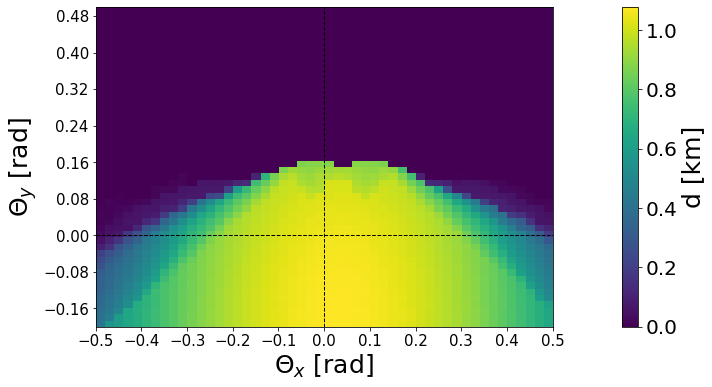

In [46]:
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(25, 20))
ax = fig.add_subplot(311)
ax.set_xlabel("$\Theta_x$ [rad]", fontsize = 25)
ax.set_ylabel("$\Theta_y$ [rad]", fontsize = 25)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

extent=(-0.5,0.5,-0.2,0.5)
im = plt.imshow(trav_distance, interpolation='nearest', extent=extent, origin='upper')

#ax.xaxis.tick_top()

# Color bar
clb = plt.colorbar()
clb.set_label('d [km]', fontsize = 25)
clb.ax.tick_params(labelsize = 20)

# Set tick labels

# labelsx = np.round(np.linspace(-nBars*theta, nBars*theta, 11),1)
# labelsy = np.round(np.linspace(-nBars*theta, nBars*theta, 11),1)
# ax.set_xticklabels(labelsx.astype(int))
# ax.set_yticklabels(labelsy.astype(int))

# center location
plt.axvline(x=0, color='k', lw=1, linestyle='--')
plt.axhline(y=0, color='k', lw=1, linestyle='--')


# Increase tick labels
ax.tick_params(axis='both', which='major', labelsize=15)

plt.savefig('figures/Fuji_P1.eps', format='eps', bbox_inches='tight', pad_inches=0)


## Save data 

In [47]:
f = open("data/Fuji_P1.dat", "w")
f.write("# Op %f %f %f \n" % (Po_Lat, Po_Log, Po_Ele)) # Observation point Lat, Long, Alt
f.write("# Pp %f %f %f \n" % (Pp_Lat, Pp_Log, Pp_Ele))
f.write("# A %f %f %f %f \n" % (Lat_up, Lat_low, Log_up, Log_low))
f.write("# cenith[rad] azimuth[rad] distance[km] \n")

for i in range(Np):
    for j in range(Np):
        f.write("%f %f %f \n" % (cenith[i], azimuth[j], trav_distance[i,j])) 
f.close

<function TextIOWrapper.close()>

# Installation of resources

In [16]:
!pip3.9 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


In [17]:
!pip3.9 install --user scipy 

You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.


In [18]:
!pip3.9 install pyproj

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3.9 -m pip install --upgrade pip' command.
